<a href="https://colab.research.google.com/github/olley102/PopulationCountClustering/blob/main/gpw_optical_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optical flow applied to GPWv411 Population Count dataset.

## 1. Load GPW rectangles from GDrive

In [ ]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls '/content/drive/My Drive/GoogleEarthEngine'

GPW_v411_pc_time0.tif  GPW_v411_pc_time2.tif  GPW_v411_pc_time4.tif
GPW_v411_pc_time1.tif  GPW_v411_pc_time3.tif


In [ ]:
import rasterio

In [ ]:
import numpy as np

In [ ]:
with rasterio.open('/content/drive/My Drive/GoogleEarthEngine/GPW_v411_pc_time0.tif', 'r') as ds:
  time0 = ds.read()

gpw = np.zeros((time0.shape[1], time0.shape[2], 5), dtype='float')
gpw[..., 0] = time0[0]

for i in range(4):
  with rasterio.open(f'/content/drive/My Drive/GoogleEarthEngine/GPW_v411_pc_time{i+1}.tif', 'r') as ds:
    gpw[..., i+1] = ds.read()[0]

gpw[np.isnan(gpw)] = 0.0

In [ ]:
import matplotlib.pyplot as plt

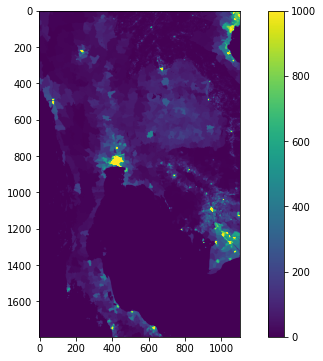

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()
im = ax.imshow(gpw[..., 0], vmin=0, vmax=1000)
fig.colorbar(im, ax=ax)
fig.show()

## 2. Optical flow iteration

In [ ]:
!git clone https://github.com/olley102/PopulationCountClustering.git

fatal: destination path 'CommunityDetectionURSS' already exists and is not an empty directory.


In [ ]:
import sys
sys.path.append('/content/PopulationCountClustering')

In [ ]:
from image_processing import optical_flow

In [ ]:
uv = optical_flow.iteration(gpw, 1, alpha=10, use_previous=True, centering=(0, 0, 0))

In [ ]:
uv.shape

(2, 1796, 1105, 5)

## 3. Plot vector field

In [ ]:
threshold = 0.9999

In [ ]:
mag = uv[0]**2 + uv[1]**2
mask = mag >= np.quantile(mag, threshold, axis=(0, 1))

In [ ]:
mask.shape

(1796, 1105, 5)

In [ ]:
uv_th = uv[:, mask]

In [ ]:
uv_th.shape

(2, 995)

In [ ]:
X = np.array(np.where(mask))

In [ ]:
X_frames = [X[:-1, X[2] == i] for i in range(5)]

In [ ]:
uv_th_frames = [uv_th[:, X[2] == i] for i in range(5)]

In [ ]:
years = ['2000', '2005', '2010', '2015', '2020']

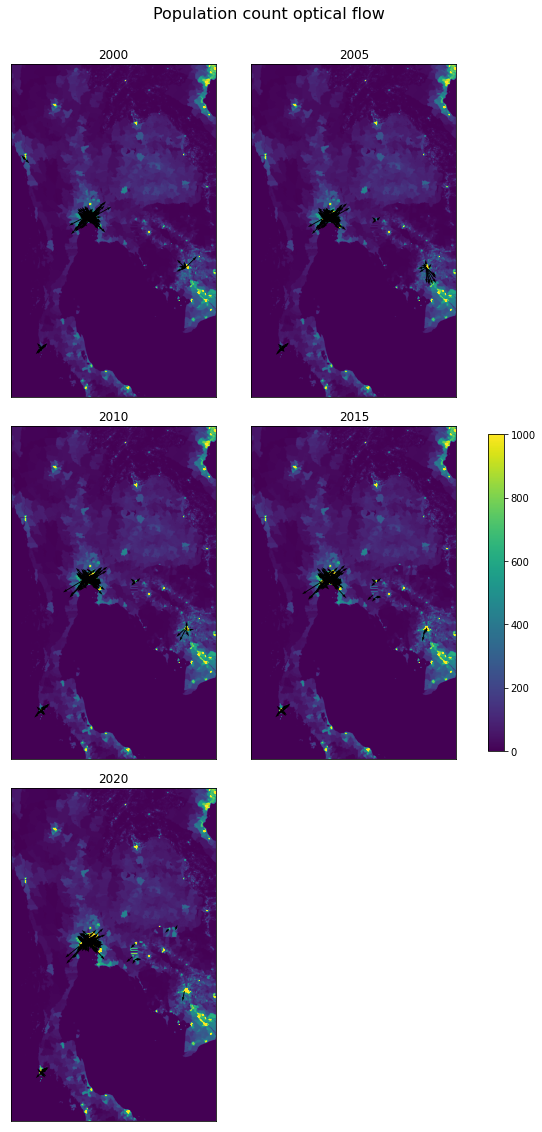

In [ ]:
fig = plt.figure(figsize=(9, 16))
fig.suptitle('Population count optical flow', fontsize=16)

axes = []

for i in range(5):
  axes.append(fig.add_subplot(3, 2, i+1))
  im = axes[i].imshow(gpw[..., i], vmin=0, vmax=1000)
  axes[i].xaxis.set_visible(False)
  axes[i].yaxis.set_visible(False)
  plt.quiver(X_frames[i][1,:], X_frames[i][0,:], *uv_th_frames[i])
  axes[i].set_title(years[i])

fig.tight_layout()
plt.subplots_adjust(top=0.93)
fig.colorbar(im, ax=axes, shrink=0.3)

In [ ]:
def divergence(f):
  return np.sum(np.gradient(f, axis=0), axis=0)

In [ ]:
uv_div = divergence(uv)

In [ ]:
uv_div.shape

(1796, 1105, 5)

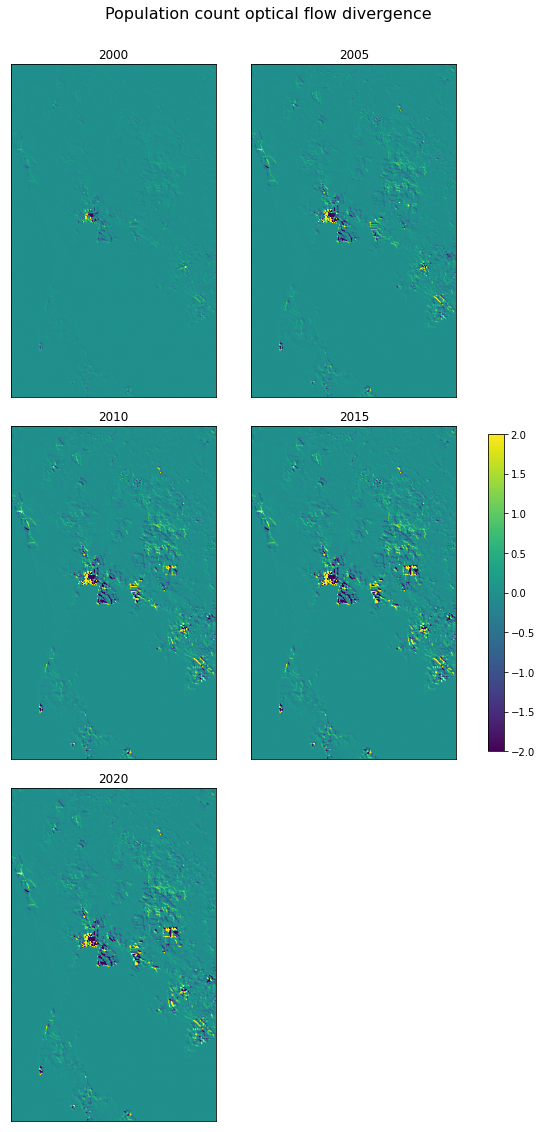

In [ ]:
fig = plt.figure(figsize=(9, 16))
fig.suptitle('Population count optical flow divergence', fontsize=16)

axes = []

for i in range(5):
  axes.append(fig.add_subplot(3, 2, i+1))
  im = axes[i].imshow(uv_div[..., i], vmin=-2, vmax=2)
  axes[i].xaxis.set_visible(False)
  axes[i].yaxis.set_visible(False)
  axes[i].set_title(years[i])

fig.tight_layout()
plt.subplots_adjust(top=0.93)
fig.colorbar(im, ax=axes, shrink=0.3)

## 4. Install packages for geographical plotting

In [ ]:
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely
!pip install shapely --no-binary shapely

Found existing installation: Shapely 1.8.2
Uninstalling Shapely-1.8.2:
  Successfully uninstalled Shapely-1.8.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Shapely-1.8.2.tar.gz (198 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shapely: filename=Shapely-1.8.2-cp37-cp37m-linux_x86_64.whl size=668935 sha256=9790bdcf0a49bc56092625868a468e69815fa29ad748064a5b905aaf97589a06
  Stored in directory: /root/.cache/pip/wheels/2f/9e/07/e9e90942b4e31275785d2f7e455607bfe876e53906307f80cd
Successfully built shapely


In [ ]:
!pip install scitools-iris

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 5. Geographical plotting

In [ ]:
import iris
import iris.plot as iplt
import cartopy.crs as ccrs

In [ ]:
from iris.coords import DimCoord
from iris.cube import Cube

In [ ]:
long_start = 97.0
lat_start = 20.6
long_end = 106.2
lat_end = 5.7

In [ ]:
gpw.shape

(1796, 1105, 5)

In [ ]:
latitude = DimCoord(np.linspace(lat_start, lat_end, gpw.shape[0]), standard_name='latitude', units='degrees')
longitude = DimCoord(np.linspace(long_start, long_end, gpw.shape[1]), standard_name='longitude', units='degrees')

In [ ]:
dummy_cube = Cube(np.zeros(gpw.shape[:2], dtype=np.float32), dim_coords_and_dims=[(latitude, 0), (longitude, 1)])

### 5.1 Divergence

In [ ]:
div_cube = dummy_cube.copy(data=uv_div[..., 0])

/usr/local/lib/python3.7/dist-packages/iris/coords.py:1808: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  "contiguous bounds.".format(self.name())
/usr/local/lib/python3.7/dist-packages/iris/coords.py:1808: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  "contiguous bounds.".format(self.name())


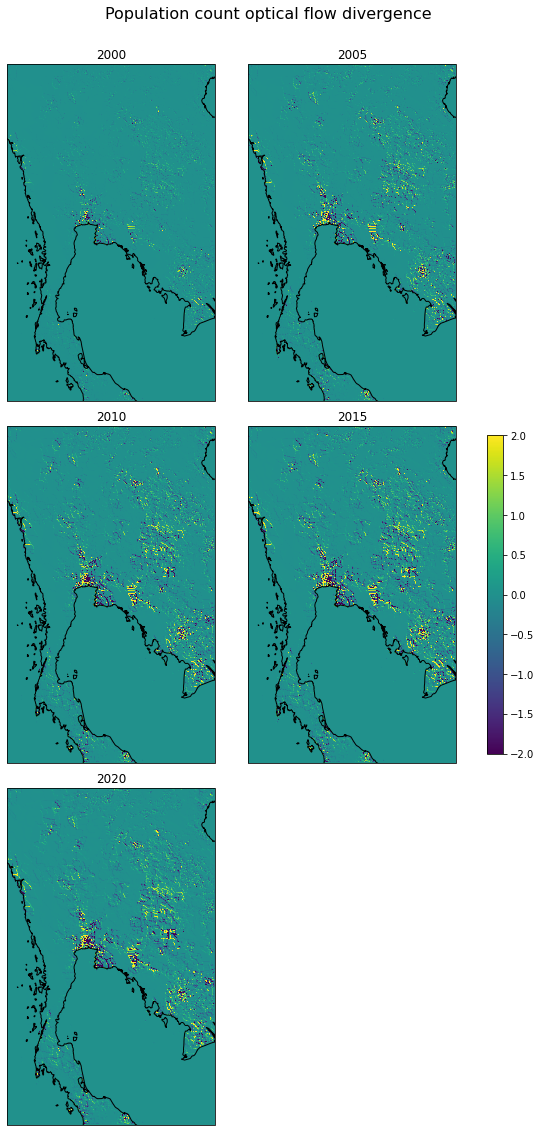

In [ ]:
fig = plt.figure(figsize=(9, 16))
fig.suptitle('Population count optical flow divergence', fontsize=16)
crs_latlon = ccrs.PlateCarree()

axes = []

for i in range(5):
  div_cube = dummy_cube.copy(data=uv_div[..., i])

  axes.append(fig.add_subplot(3, 2, i+1, projection=crs_latlon))
  cmesh = iplt.pcolormesh(div_cube, vmin=-2, vmax=2)
  axes[i].xaxis.set_visible(False)
  axes[i].yaxis.set_visible(False)
  axes[i].set_title(years[i])
  axes[i].set_xlim(long_start, long_end)
  axes[i].set_ylim(lat_end, lat_start)
  axes[i].coastlines()

fig.tight_layout()
plt.subplots_adjust(top=0.93)
fig.colorbar(cmesh, ax=axes, shrink=0.3)

### 5.2 Vector fields

In [ ]:
u_cube = dummy_cube.copy(data=uv[0, :, :, 0])
v_cube = dummy_cube.copy(data=uv[1, :, :, 0])

w = (u_cube**2 + v_cube**2) ** 0.5

In [ ]:
lat_reduce = latitude.points[X_frames[0][0, :]]
lon_reduce = longitude.points[X_frames[1][1, :]]

/usr/local/lib/python3.7/dist-packages/iris/coords.py:1808: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  "contiguous bounds.".format(self.name())
/usr/local/lib/python3.7/dist-packages/iris/coords.py:1808: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  "contiguous bounds.".format(self.name())


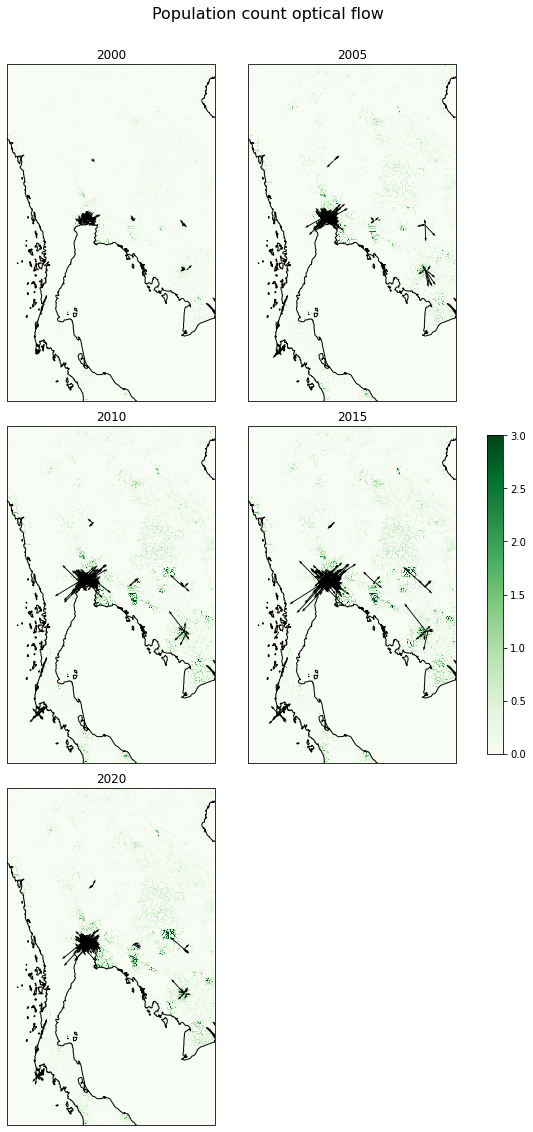

In [ ]:
fig = plt.figure(figsize=(9, 16))
fig.suptitle('Population count optical flow', fontsize=16)

quiver_kwargs = {'headwidth': 2.5, 'headlength': 3.5, 'scale': 50,
                 'scale_units': 'xy', 'angles': 'uv', 'zorder': 2,
                 'rasterized': None}
cmesh_kwargs = {'cmap': 'Greens', 'vmin': 0, 'vmax': 3}

axes = []

for i in range(5):
  u_cube = dummy_cube.copy(data=uv[0, :, :, i])
  v_cube = dummy_cube.copy(data=uv[1, :, :, i])

  w = (u_cube**2 + v_cube**2) ** 0.5

  # u_stride = u_cube[::stride, ::stride]
  # v_stride = v_cube[::stride, ::stride]

  axes.append(fig.add_subplot(3, 2, i+1, projection=crs_latlon))

  # quiver = iplt.quiver(u_cube, v_cube, axes=axes[i])

  plt.quiver(lon_reduce, lat_reduce, *uv_th_frames[i], **quiver_kwargs)
  cmesh = iplt.pcolormesh(w, **cmesh_kwargs)

  axes[i].xaxis.set_visible(False)
  axes[i].yaxis.set_visible(False)
  axes[i].set_title(years[i])
  axes[i].set_xlim(long_start, long_end)
  axes[i].set_ylim(lat_end, lat_start)
  axes[i].coastlines()

fig.tight_layout()
plt.subplots_adjust(top=0.93)
fig.colorbar(cmesh, ax=axes, shrink=0.3)

### 5.3 Divergence and vectors

/usr/local/lib/python3.7/dist-packages/iris/coords.py:1808: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  "contiguous bounds.".format(self.name())
/usr/local/lib/python3.7/dist-packages/iris/coords.py:1808: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  "contiguous bounds.".format(self.name())


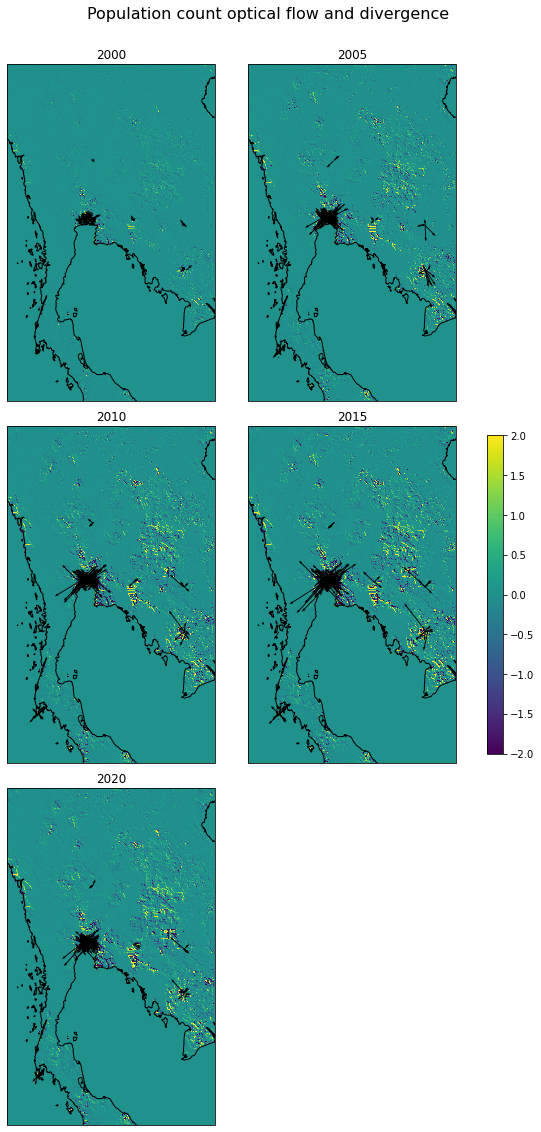

In [ ]:
fig = plt.figure(figsize=(9, 16))
fig.suptitle('Population count optical flow and divergence', fontsize=16)

quiver_kwargs = {'headwidth': 2.5, 'headlength': 3.5, 'scale': 50,
                 'scale_units': 'xy', 'angles': 'uv', 'zorder': 2,
                 'rasterized': None}
cmesh_kwargs = {'vmin': -2, 'vmax': 2}

axes = []

for i in range(5):
  div_cube = dummy_cube.copy(data=uv_div[..., i])

  axes.append(fig.add_subplot(3, 2, i+1, projection=crs_latlon))
  cmesh = iplt.pcolormesh(div_cube, **cmesh_kwargs)

  plt.quiver(lon_reduce, lat_reduce, *uv_th_frames[i], **quiver_kwargs)

  axes[i].xaxis.set_visible(False)
  axes[i].yaxis.set_visible(False)
  axes[i].set_title(years[i])
  axes[i].set_xlim(long_start, long_end)
  axes[i].set_ylim(lat_end, lat_start)
  axes[i].coastlines()

fig.tight_layout()
plt.subplots_adjust(top=0.93)
fig.colorbar(cmesh, ax=axes, shrink=0.3)